## Alkanes experiment

This experiment concerns the alkanes data set provided by [Micheli](http://pages.di.unipi.it/micheli/dataset/).
It consists of a trees representing alkanes, associated with boiling points. We first check the runtimes of all heuristics for the A* algorithm and verify that they all provide the same result. We also compute the standard TED and the constrained TED for reference.

In [1]:
# load the data
import alkanes_parser
import time
import uted
import numpy as np
import edist.ted as ted
from tqdm import tqdm

trees, temperature = alkanes_parser.parse_alkanes()
N = len(trees)
temperature = np.array(temperature)

In [2]:
# compute pairwise distances with unit delta and with custom delta
value_map = {'c' : 0, 'ch' : 1, 'ch2' : 2, 'ch3' : 3, 'ch3f' : 3, 'ch4' : 4}
def delta(x, y):
    if x is None or y is None:
        return 4
    return abs(value_map[x] - value_map[y])
deltas = [None, delta]
delta_labels = ['unit', 'custom']

In [3]:
algorithms = [1, 2, 3, 'yoshino', 'ted', 'uted_const']

D = np.zeros((len(algorithms), len(deltas), N, N))
times = np.zeros((len(algorithms), len(deltas), N, N))
num_nodes = np.zeros((len(algorithms)-2, len(deltas), N, N))
for k in range(len(algorithms)):
    algorithm = algorithms[k]
    for d in range(len(deltas)):
        if algorithm == 'yoshino':
            delta = None
        else:
            delta = deltas[d]
        start_time = time.time()
        for i in tqdm(range(N)):
            x_nodes, x_adj = trees[i]
            for j in range(N):
                y_nodes, y_adj = trees[j]
                start_time = time.time()
                if algorithm in [1, 2, 3, 'yoshino']:
                    D[k, d, i, j], _, num_nodes[k, d, i, j] = uted.uted_astar(x_nodes, x_adj, y_nodes, y_adj, heuristic = algorithm, delta = delta)
                elif algorithm == 'ted':
                    D[k, d, i, j] = ted.ted(x_nodes, x_adj, y_nodes, y_adj, delta = delta)
                elif algorithm == 'uted_const':
                    D[k, d, i, j] = uted.uted_constrained(x_nodes, x_adj, y_nodes, y_adj, delta = delta)
                else:
                    raise ValueError('unknown algorithm: %s' % str(algorithm))
                times[k, d, i, j] = time.time() - start_time

100%|██████████| 150/150 [00:27<00:00,  5.47it/s]


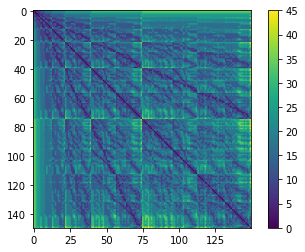

In [22]:
import matplotlib.pyplot as plt
plt.imshow(D[2, 1, :, :])
plt.colorbar()
plt.show()

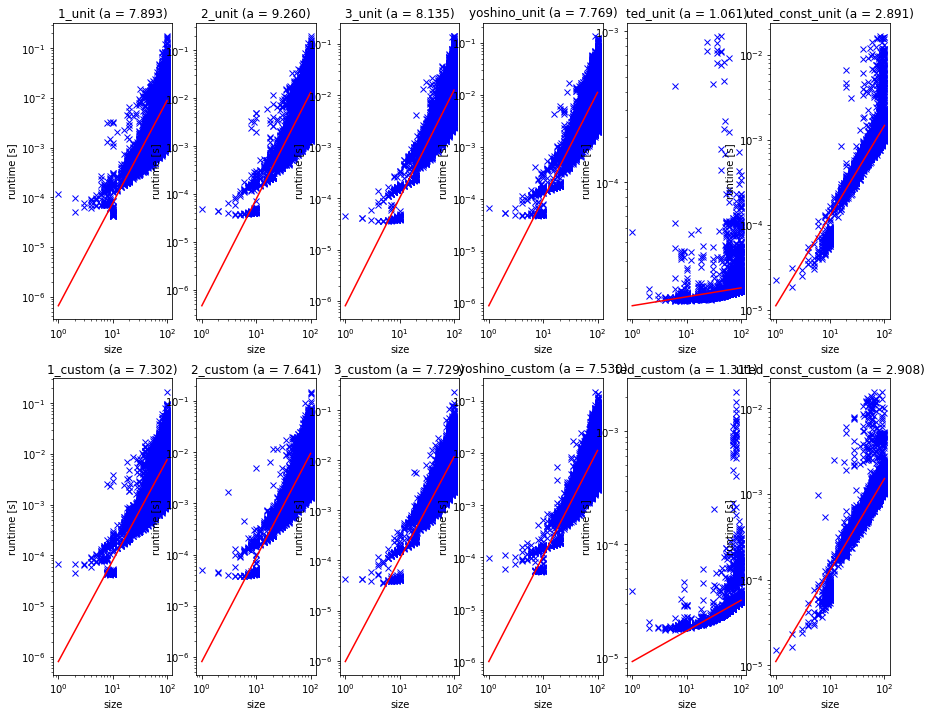

In [24]:
# show runtime plots
sizes = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        sizes[i, j] = (len(trees[i][0]) * len(trees[j][0]))

from sklearn.linear_model import Ridge 
sizes_flat = sizes.flatten()
plt.figure(figsize=(15, 12))
for d in range(len(deltas)):
    for k in range(len(algorithms)):
        plt.subplot(len(deltas), len(algorithms), len(algorithms)*d+k+1)
        times_flat = times[k, d, :, :].flatten()
        plt.loglog(sizes_flat, times_flat, 'bx')
        model = Ridge()
        model.fit(np.expand_dims(np.log(sizes_flat), 1), np.log(times_flat), 1)
        sizes_pred = np.array([1., 2., 5., 10., 100.])
        times_pred = np.exp(model.predict(np.expand_dims(np.log(sizes_pred), 1)))
        plt.loglog(sizes_pred, times_pred, 'r-')
        plt.xlabel('size')
        plt.ylabel('runtime [s]')
        plt.title('%s_%s (a = %.3f)' % (str(algorithms[k]), delta_labels[d], np.exp(model.coef_[0])))
plt.show()

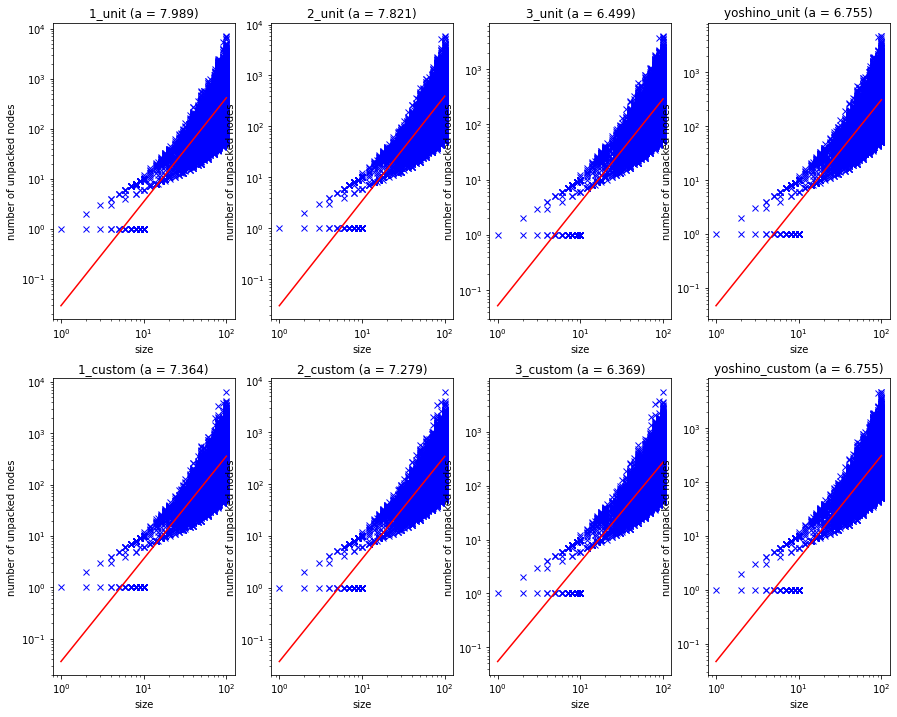

In [28]:
# show number of nodes plots
plt.figure(figsize=(15, 12))
for d in range(len(deltas)):
    for k in range(len(algorithms)-2):
        plt.subplot(len(deltas), len(algorithms)-2, d*(len(algorithms)-2) + k+1)
        nodes_flat = num_nodes[k, d, :, :].flatten()
        plt.loglog(sizes_flat, nodes_flat, 'bx')
        model = Ridge()
        model.fit(np.expand_dims(np.log(sizes_flat), 1), np.log(nodes_flat), 1)
        sizes_pred = np.array([1., 2., 5., 10., 100.])
        nodes_pred = np.exp(model.predict(np.expand_dims(np.log(sizes_pred), 1)))
        plt.loglog(sizes_pred, nodes_pred, 'r-')
        plt.xlabel('size')
        plt.ylabel('number of unpacked nodes')
        plt.title('%s_%s (a = %.3f)' % (str(algorithms[k]), delta_labels[d], np.exp(model.coef_[0])))
plt.show()

## Comparison to ordered and constrained unordered tree edit distance

A challenge of the A* algorithm is that, in the worst case, it searches a huge chunk of the exponentially large set of possible alignments. This can not really be prevented, either (if P != NP) because the unordered tree edit distance is MAX SNP hard. However, we can compute the ordered tree edit distance and a constrained version of the unordered tree edit distance in polynomial time. We now check how much these two distances overestimate the actual unordered tree edit distance.

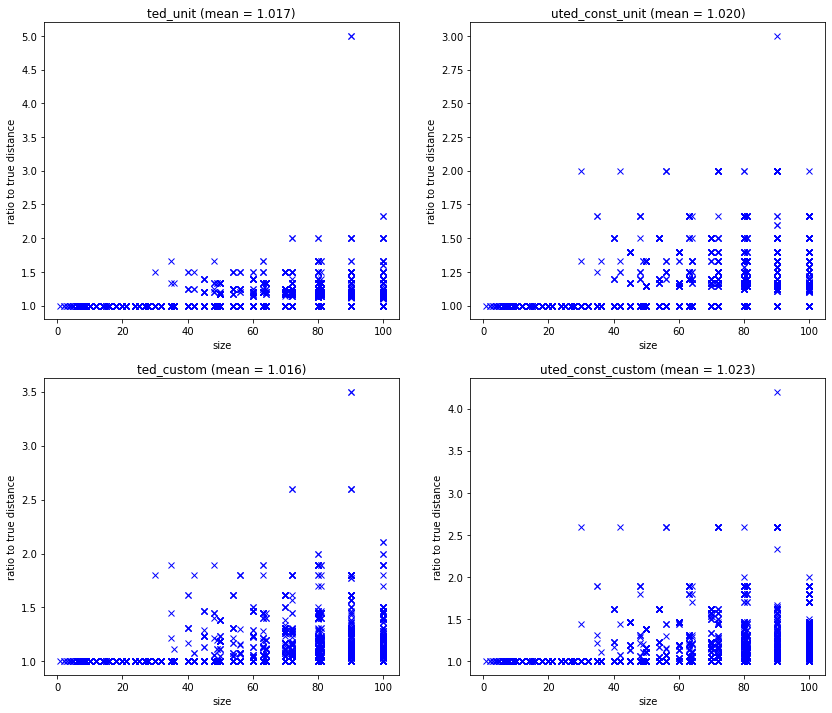

In [31]:
# compare the ratio to the unordered distance
ratios = np.zeros((len(algorithms)-4, len(deltas), N, N))
offset = 1E-5
for d in range(len(deltas)):
    for k in range(4, len(algorithms)):
        ratios[k-4, d, :, :] = np.exp(np.abs(np.log(D[0, d, :, :] + offset) - np.log(D[k, d, :, :] + offset)))

plt.figure(figsize=(14, 12))
for d in range(len(deltas)):
    for k in range(4, len(algorithms)):
        plt.subplot(len(deltas), len(algorithms)-4, d*(len(algorithms)-4) + k-4+1)
        ratios_flat = ratios[k-4, d, :, :].flatten()
        plt.plot(sizes.flatten(), ratios_flat, 'bx')
        plt.xlabel('size')
        plt.ylabel('ratio to true distance')
        avg = np.exp(np.mean(np.log(ratios_flat)))
        plt.title('%s_%s (mean = %.3f)' % (str(algorithms[k]), delta_labels[d], avg))
plt.show()

In [34]:
# store results
Resmat = [sizes_flat]
headers = ['size']
for d in range(len(deltas)):
    for k in range(len(algorithms)):
        Resmat.append(times[k, d, :, :].flatten())
        headers.append('time_%s_%s' % (str(algorithms[k]), delta_labels[d]))
        if k < 4:
            Resmat.append(num_nodes[k, d, :, :].flatten())
            headers.append('num_nodes_%s_%s' % (str(algorithms[k]), delta_labels[d]))
        else:
            Resmat.append(ratios[k-4, d, :, :].flatten())
            headers.append('ratio_%s_%s' % (str(algorithms[k]), delta_labels[d]))
Resmat = np.stack(Resmat, 1)
np.savetxt('alkanes_runtimes.csv', Resmat, fmt = '%g', header = '\t'.join(headers), delimiter = '\t', comments = '')

## Temperature regression

Now, we actually go for a similarity search. In particular, we try to perform a $k$-nearest neighbor regression on the edit distance to predict the boiling point of the molecules in this data set.

First, though, we visualize the spatial structure using t-SNE.

/home/bpaassen/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(
/home/bpaassen/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(
/home/bpaassen/.local/lib/python3.9/site-packages/sklearn/manifo

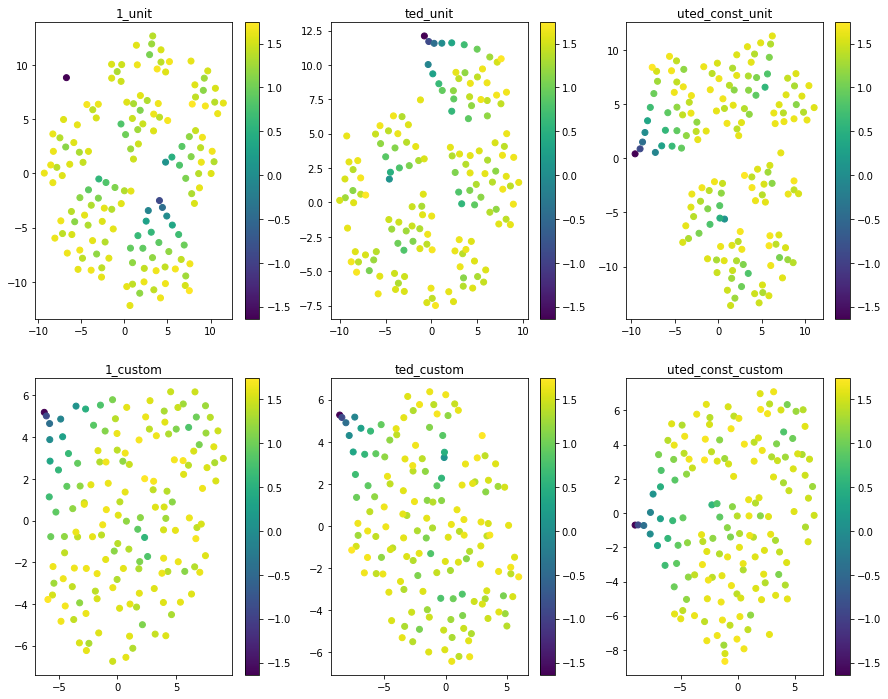

In [47]:
from sklearn.manifold import TSNE
ResMat = [np.expand_dims(temperature, 1)]
headers = ['temperature']
plt.figure(figsize=(15, 12))
sub_idx = 1
for d in range(len(deltas)):
    for k in [0, 4, 5]:
        model = TSNE(metric = 'precomputed')
        X = model.fit_transform(D[k, d, :, :])
        plt.subplot(len(deltas), len(algorithms)-3, sub_idx)
        sub_idx += 1
        plt.scatter(X[:, 0], X[:, 1], c = temperature)
        plt.colorbar()
        plt.title('%s_%s' % (algorithms[k], delta_labels[d]))
        ResMat.append(X)
        headers.append('%s_%s_x' % (algorithms[k], delta_labels[d]))
        headers.append('%s_%s_y' % (algorithms[k], delta_labels[d]))
plt.show()

In [50]:
# perform a 10-fold crossvalidation to perform the regression
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor
n_splits = 15
max_K = 5
errs = np.zeros((len(algorithms), len(deltas), max_K, n_splits))
preds = np.zeros((len(algorithms), len(deltas), max_K, N))

kf = KFold(n_splits = n_splits)
f = 0
for train_index, test_index in kf.split(X):
    for d in range(len(deltas)):
        for k in [0, 4, 5]:
            D_k = D[k, d, :, :]
            for K in range(max_K):
                model = KNeighborsRegressor(K+1, weights = 'distance', metric = 'precomputed')
                model.fit(D_k[train_index, :][:, train_index], temperature[train_index])
                preds[k, d, K, test_index] = model.predict(D_k[test_index, :][:, train_index])
                errs[k, d, K, f] = np.sqrt(np.mean(np.square(temperature[test_index] - preds[k, d, K, test_index])))
    f += 1

ResMat2 = []
headers2 = []
for d in range(len(deltas)):
    for k in [0, 4, 5]:
        row = '%s_%s' % (algorithms[k], delta_labels[d])
        headers2.append('%s_%s' % (algorithms[k], delta_labels[d]))
        means = np.mean(errs[k, d, :, :], 1)
        stds  = np.std(errs[k, d, :, :], 1)
        ResMat2.append(means)
        ResMat2.append(stds)
        for K in range(max_K):
            row += '\t& $%.3f \\pm %.3f$' % (means[K], stds[K])
        print(row + '\\\\')
np.savetxt('alkanes_rmses.csv', np.stack(ResMat2, 1), fmt = '%g', header = '\t'.join(headers2), delimiter = '\t', comments = '')

1_unit	& $0.310 \pm 0.189$	& $0.281 \pm 0.206$	& $0.279 \pm 0.221$	& $0.273 \pm 0.225$	& $0.273 \pm 0.236$\\
ted_unit	& $0.312 \pm 0.189$	& $0.280 \pm 0.206$	& $0.278 \pm 0.221$	& $0.266 \pm 0.227$	& $0.266 \pm 0.236$\\
uted_const_unit	& $0.310 \pm 0.189$	& $0.282 \pm 0.206$	& $0.280 \pm 0.222$	& $0.266 \pm 0.229$	& $0.266 \pm 0.240$\\
1_custom	& $0.297 \pm 0.191$	& $0.255 \pm 0.207$	& $0.243 \pm 0.221$	& $0.247 \pm 0.230$	& $0.248 \pm 0.239$\\
ted_custom	& $0.297 \pm 0.191$	& $0.256 \pm 0.207$	& $0.243 \pm 0.221$	& $0.249 \pm 0.229$	& $0.249 \pm 0.237$\\
uted_const_custom	& $0.297 \pm 0.191$	& $0.256 \pm 0.207$	& $0.245 \pm 0.221$	& $0.248 \pm 0.230$	& $0.246 \pm 0.239$\\


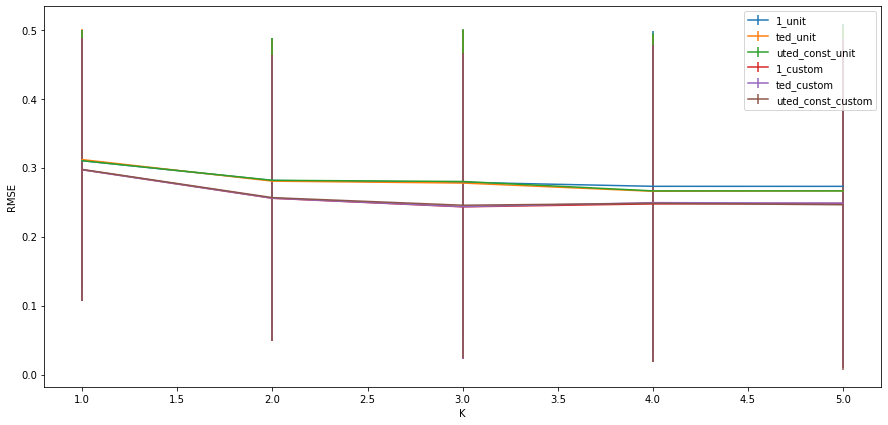

In [41]:
# plot results
plt.figure(figsize=(15, 7))
method_labels = []
for d in range(len(deltas)):
    for k in [0, 4, 5]:
        method_labels.append('%s_%s' % (algorithms[k], delta_labels[d]))
        plt.errorbar(list(range(1, max_K+1)), np.mean(errs[k, d, :, :], 1), yerr = np.std(errs[k, d, :, :], 1))
plt.legend(method_labels)
plt.xlabel('K')
plt.ylabel('RMSE')
plt.show()

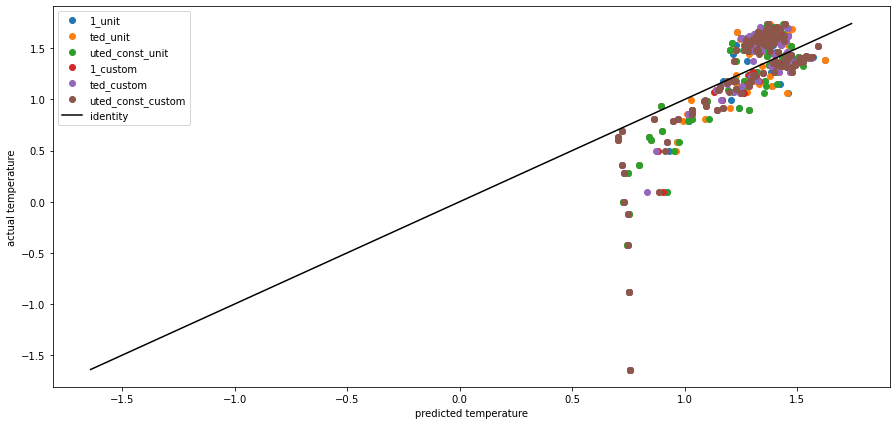

In [42]:
plt.figure(figsize=(15, 7))
for d in range(len(deltas)):
    for k in [0, 4, 5]:
        plt.plot(preds[k, d, -1, :], temperature, 'o')
plt.plot([np.min(temperature), np.max(temperature)], [np.min(temperature), np.max(temperature)], 'k-')
plt.xlabel('predicted temperature')
plt.ylabel('actual temperature')
plt.legend(method_labels + ['identity'])
plt.show()

In [48]:
# store results
for k in [0, 4, 5]:
    for d in range(len(deltas)):
        headers.append('%s_%s' % (algorithms[k], delta_labels[d]))
        ResMat.append(np.expand_dims(preds[k, d, -1, :], 1))
np.savetxt('alkanes_5nn_prediction.csv', np.concatenate(ResMat, 1), fmt = '%g', header = '\t'.join(headers), delimiter = '\t', comments = '')